<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/DLG_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLG - Iris Dataset
This notebook modifies the code in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) to work with the Iris Dataset.

In [ ]:
# setting up libraries and device
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

from random import randint

from sklearn.datasets import load_iris
dst = load_iris()

print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

1.12.1+cu113
Running on cuda


In [ ]:
# auxiliary functions for NN - conver to onehot and loss function
def label_to_onehot(target, num_classes = 3):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [ ]:
# a random fully connected neural network with random weights and biases
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(4, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 3),
            act(),
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        return out
    
net = FcNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [ ]:
# DLG algorithm on a given flower and returns the hypothesized input
def DLG(flower_index, verbose = True):

    gt_data = torch.tensor(dst.data[flower_index, :]).to(device)
    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.tensor(dst.target[flower_index]).to(device)
    gt_label = gt_label.view(1)
    gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

    # print out (data, label) and verify onehot
    if (verbose):
        print(f"gt_data: {gt_data}")
        print(f"gt_label: {gt_label}")
        print(f"gt_onehot_label: {gt_onehot_label}")
        print(f"flower {flower_index} has label (gt, onehot) = ({gt_label.item()}, {torch.argmax(gt_onehot_label, dim=-1).item()})")

    # compute original gradient 
    out = net(gt_data.float())
    y = criterion(out, gt_onehot_label)
    dy_dx = torch.autograd.grad(y, net.parameters())

    # share the gradients with other clients
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))

    # generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    if (verbose):
        print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

    # identify (data, label) using LBFGS on the squared difference between the original and guessed gradient
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

    global opt_steps
    opt_steps = 0
    for iters in range(10):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data) 
            
            global opt_steps
            opt_steps += 1
            #print(f"prediction: {pred} from data: {dummy_data.data} and label: {dummy_label}") # uncomment to see optimization updates
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label)
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
            
            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()

            grad_diff.backward()
            
            return grad_diff
        
        optimizer.step(closure)
        current_loss = closure()
        if (verbose):
            print(iters, "%.4f" % current_loss.item())
        
        # if current_loss is small enough, then the model has 'converged'
        if (current_loss < 1e-9):
            break
    
    # compare results
    if (verbose):
        print(f"Original data: {gt_data}")
        print(f"Predicted data: {dummy_data}")
        print(f"Original label: {gt_label.item()}")
        print(f"Predicted label: {torch.argmax(dummy_label).item()}")
        print(f"Label SE: {((gt_data - dummy_data)**2).sum()}")
    

    return dummy_data, ((gt_data - dummy_data)**2).sum().item(), opt_steps

In [ ]:
# testing DLG on entire flower dataset
len = dst.data.shape[0]
errors = []
optimization_steps = []
for i in range(len):
    _, SE, steps = DLG(i, False)
    errors.append(SE)
    optimization_steps.append(steps)
    
print(errors)
print(optimization_steps)

[1.9208433798233767e-07, 1.252709030639823e-07, 1.0177288531016896e-07, 1.7586277651045668e-07, 1.5673327406808422e-05, 1.44645635628935e-07, 1.0673208155521654e-07, 1.511053007164093e-07, 1.7037885527298948e-07, 8.74156538442178e-08, 1.5966886587085671e-07, 2.0462893979289615e-07, 2.9599762342529896e-07, 1.1833269199190536e-07, 3.7584510359969064e-07, 0.00012933581402150792, 885267205277.7576, 1.577939612220417e-07, 1.2482503567669248e-07, 2.1369017297313655e-05, 1.6474992925440217e-08, 2930891.692951436, 2.1898337937661302e-07, 1.2637908938042905e-07, 1.089353519835391e-07, 1.0057464465694645e-07, 1.8318716243476022e-07, 0.0002601414436382091, 1.2006896756837343e-07, 2.8109698264140385e-07, 1.9238595840859116e-07, 4.5735235157199765e-05, 1.3855974243757657e-07, 3.0918948997519986e-07, 0.00034379553505246174, 4.55054724202547e-06, 2.7508202553149775e-07, 1.1112600156494475e-07, 1.3615056403162815e-07, 5.991630738254044e-09, 0.00011330514875258048, 1.7531720917682636e-07, 2.71424225823

This graph was generated on the entire IRIS dataset consisting of 150 flowers.
It utilizes a randomly initialized fully connected NN as its prediction algorithm.


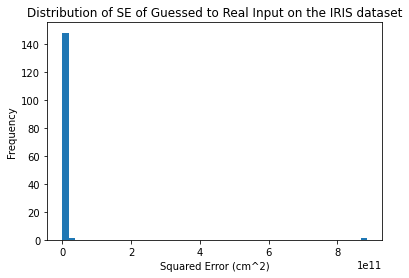

In [ ]:
# visually represent errors in a histogram
plt.hist(errors, 50)
plt.title('Distribution of SE of Guessed to Real Input on the IRIS dataset')
plt.ylabel('Frequency')
plt.xlabel('Squared Error (cm^2)')
#plt.axis([0, 2, 0, 150])
print('This graph was generated on the entire IRIS dataset consisting of 150 flowers.\nIt utilizes a randomly initialized fully connected NN as its prediction algorithm.')
#plt.savefig('single-gradient-SE.png', dpi=300)

Note that the number of optimization steps is measured in terms of the number of times the closure function is called in the LBFGS optimizer


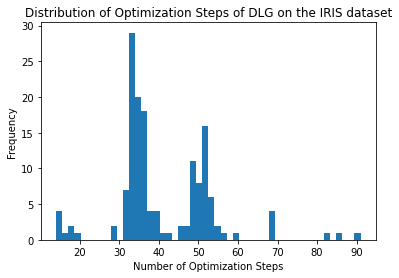

In [ ]:
# visually represent number of optimization steps
plt.hist(optimization_steps, 50)
plt.title('Distribution of Optimization Steps of DLG on the IRIS dataset')
plt.xlabel('Number of Optimization Steps')
plt.ylabel('Frequency')
#plt.savefig('single-gradient-CR.png', dpi=300)
print('Note that the number of optimization steps is measured in terms of the number of times the closure function is called in the LBFGS optimizer')